# Periodicity Analysis

To verify whether periodicity in the Covid-19 data from the Uk is a product of the reporting process, or due to some phenomenan in the underlying processes.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import fftpack
import matplotlib.pyplot as plt
from phe_api import retrieve_data

import periodic_sampling as ps
from periodic_sampling.analysis import fourier_transform, plot_fft, weekday_t_tests
from periodic_sampling.analysis import wilcoxon_signed_rank_test, kruskal_weekday_test, multiple_comparisons_correction

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
# Read in data

df = pd.DataFrame(retrieve_data(area_name='england', area_type='nation'))
df["Date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")
df.sort_values(by="Date", inplace=True); 
df.index = df.index.sort_values()
df = df[df["Date"] < "2022-02-01"]
print(df.columns.values)

['date' 'areaCode' 'newCasesByPublishDate' 'newCasesBySpecimenDate'
 'newDeaths28DaysByDeathDate' 'newDeaths28DaysByPublishDate'
 'newVirusTestsBySpecimenDate' 'newCasesPCROnlyBySpecimenDate'
 'newPCRTestsBySpecimenDate' 'Date']


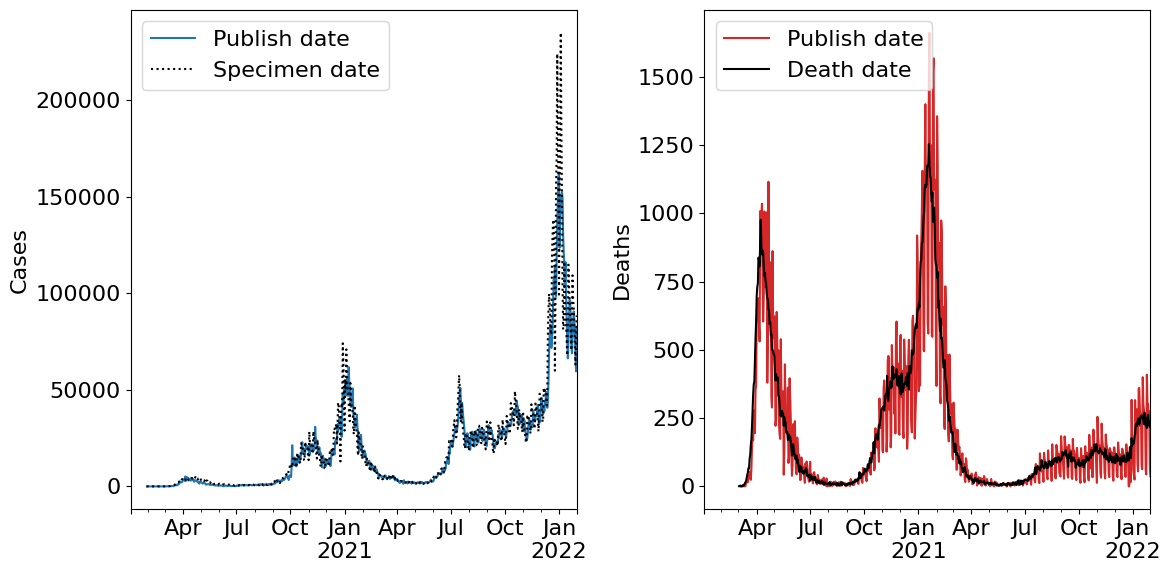

In [ ]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(1, 2, figsize=(12,6))

plot1 = df.plot.line('Date', 'newCasesByPublishDate', ax=axs[0], color='tab:blue', label='Publish date')
plot1 = df.plot.line('Date', 'newCasesBySpecimenDate', ax=axs[0], color='black', linestyle=':', label = 'Specimen date')
axs[0].set_xlabel(''); axs[0].set_ylabel('Cases')

plot2 = df.plot.line('Date', 'newDeaths28DaysByPublishDate', ax=axs[1], color='tab:red', label = 'Publish date')
plot2 = df.plot.line('Date', 'newDeaths28DaysByDeathDate', ax=axs[1], color='black', label = 'Death date')
axs[1].set_xlabel(''); axs[1].set_ylabel('Deaths')

fig.patch.set_facecolor('white') ; fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/new_cases_and_deaths.png")


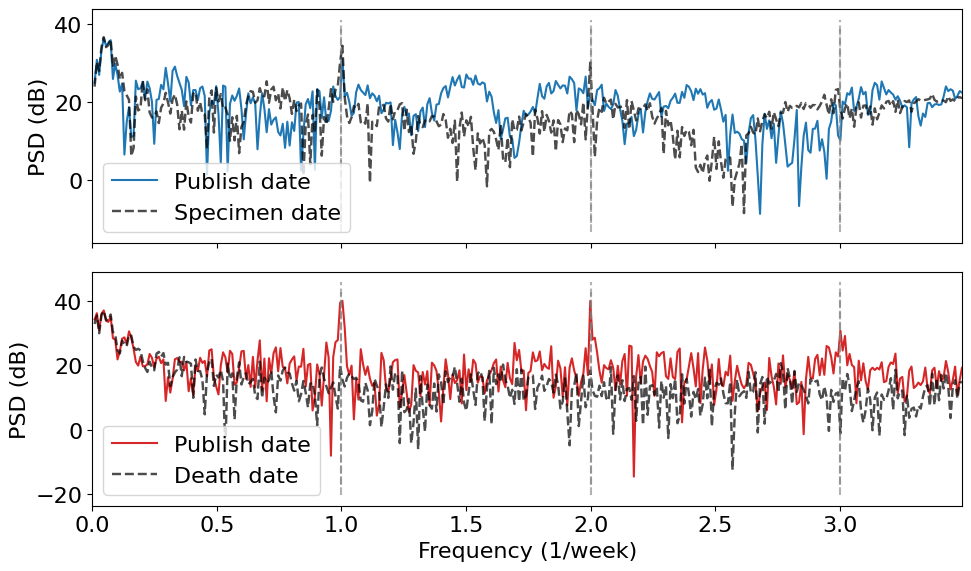

In [4]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(2, 1, figsize=(10,6))

df["Days"] = df["Date"].apply(lambda date: (date - min(df["Date"])).days)
df = ps.analysis.rel_reporting_calc(df, ['newCasesByPublishDate', 'newCasesBySpecimenDate',
                             'newDeaths28DaysByDeathDate', 'newDeaths28DaysByPublishDate'])

case_fft_pub, case_freq_pub = fourier_transform(df, column='Dif_newCasesByPublishDate', compute_psd=True)
plot_fft(case_fft_pub, case_freq_pub, ax=axs[0], color='tab:blue', label="Publish date", linewidth = 1.5)
case_fft_spec, case_freq_spec = fourier_transform(df, column='Dif_newCasesBySpecimenDate', compute_psd=True)
plot_fft(case_fft_spec, case_freq_spec, ax=axs[0], color='black', alpha=0.7, label="Specimen date", linestyle='--', linewidth = 1.75)
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft_pub, death_freq_pub = fourier_transform(df, column='Dif_newDeaths28DaysByPublishDate', compute_psd=True)
plot_fft(death_fft_pub, death_freq_pub, ax=axs[1], color='tab:red', label="Publish date", linewidth = 1.5)
death_fft_cert, death_freq_cert = fourier_transform(df, column='Dif_newDeaths28DaysByDeathDate', compute_psd=True)
plot_fft(death_fft_cert, death_freq_cert, ax=axs[1], color='black', alpha=0.7, label="Death date", linestyle='--', linewidth = 1.75)

fig.patch.set_facecolor('white'); fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_fft_cases_deaths.png")


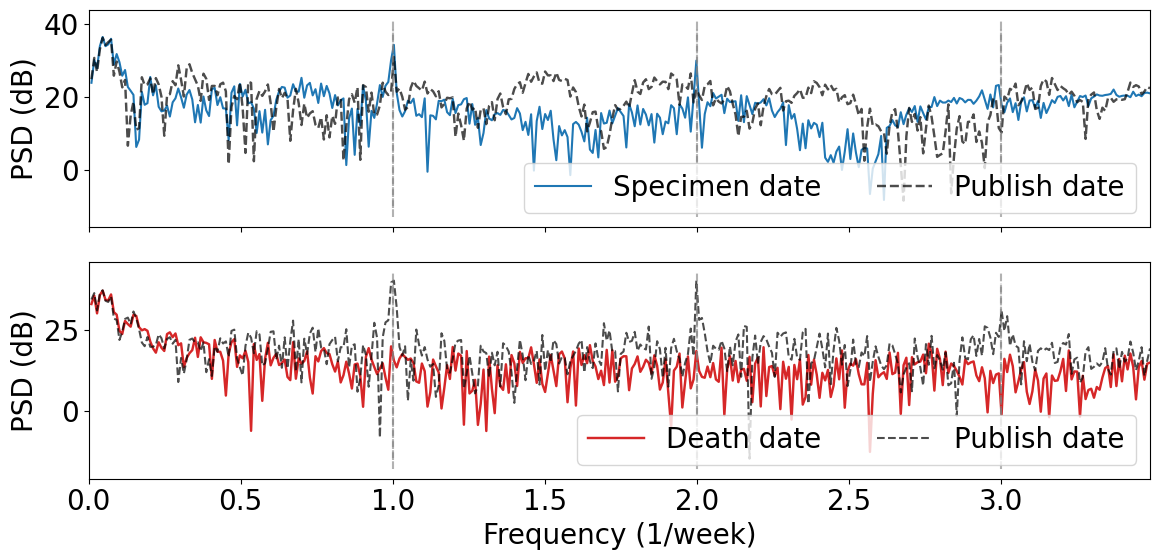

In [5]:
plt.rcParams['font.size'] = '20'
fig, axs = plt.subplots(2, 1, figsize=(12,6))

df["Days"] = df["Date"].apply(lambda date: (date - min(df["Date"])).days)
df = ps.analysis.rel_reporting_calc(df, ['newCasesByPublishDate', 'newCasesBySpecimenDate',
                             'newDeaths28DaysByDeathDate', 'newDeaths28DaysByPublishDate'])

case_fft_pub, case_freq_pub = fourier_transform(df, column='Dif_newCasesByPublishDate', compute_psd=True)
case_fft_spec, case_freq_spec = fourier_transform(df, column='Dif_newCasesBySpecimenDate', compute_psd=True)
plot_fft(case_fft_spec, case_freq_spec, ax=axs[0], color='tab:blue', label="Specimen date", linewidth = 1.5)
plot_fft(case_fft_pub, case_freq_pub, ax=axs[0], color='black', alpha=0.7, label="Publish date", linewidth = 1.75, linestyle='--')
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft_pub, death_freq_pub = fourier_transform(df, column='Dif_newDeaths28DaysByPublishDate', compute_psd=True)
death_fft_cert, death_freq_cert = fourier_transform(df, column='Dif_newDeaths28DaysByDeathDate', compute_psd=True)
plot_fft(death_fft_cert, death_freq_cert, ax=axs[1], color='tab:red', label="Death date", linewidth = 1.75)
plot_fft(death_fft_pub, death_freq_pub, ax=axs[1], color='black', alpha = 0.7, label="Publish date", linewidth = 1.5, linestyle='--')

axs[0].legend(loc=4, ncol=2);  axs[1].legend(loc=4, ncol=2)
fig.patch.set_facecolor('white'); fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_fft_cases_deaths.png")


## Weekly Patterns
We can identify periodic, weekly variation in the observed reporting factor.

In [6]:
summary = df.groupby('Weekday').median().sort_values('Day_Index')
print(summary[['Dif_newCasesByPublishDate', 'Dif_newCasesBySpecimenDate', 'Dif_newDeaths28DaysByPublishDate', 'Dif_newDeaths28DaysByDeathDate']])

           Dif_newCasesByPublishDate  Dif_newCasesBySpecimenDate  \
Weekday                                                            
Monday                      0.916211                    1.186887   
Tuesday                     0.962527                    1.134482   
Wednesday                   1.029357                    1.127949   
Thursday                    1.119377                    1.058359   
Friday                      1.096452                    0.972801   
Saturday                    1.029980                    0.782110   
Sunday                      0.943675                    0.834068   

           Dif_newDeaths28DaysByPublishDate  Dif_newDeaths28DaysByDeathDate  
Weekday                                                                      
Monday                             0.355932                        0.996284  
Tuesday                            1.458118                        1.004950  
Wednesday                          1.313793                        0.977941

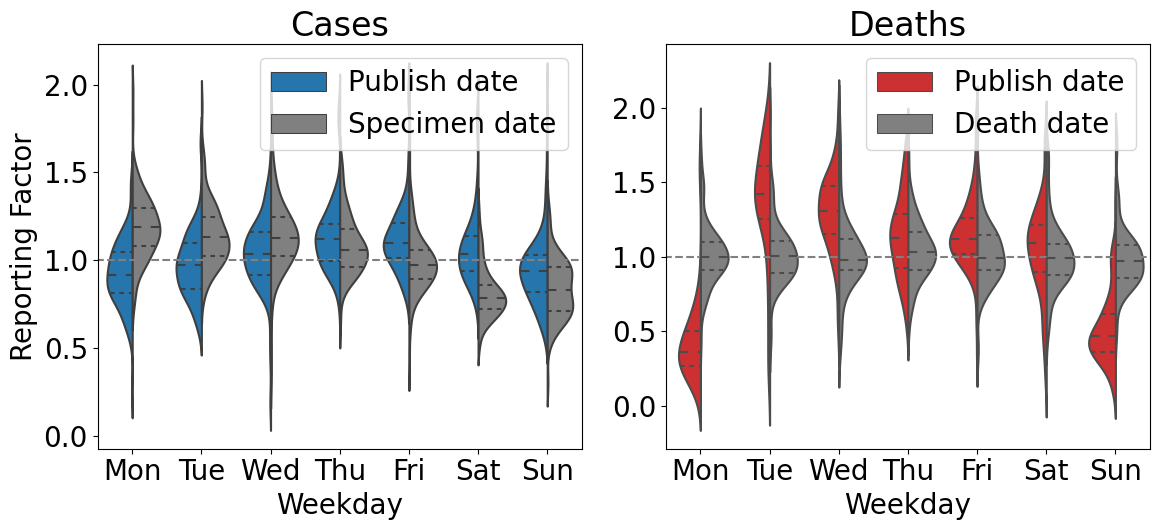

In [7]:
# separate violin for cases and deaths 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
ps.analysis.rel_reporting_violin(df.copy(), ['newCasesByPublishDate', 'newCasesBySpecimenDate'],  ax=axs[0], cutoff=2,
                   colors=['tab:blue', 'grey'], labels=["Publish date", "Specimen date"])  
ps.analysis.rel_reporting_violin(df.copy(), ['newDeaths28DaysByPublishDate', 'newDeaths28DaysByDeathDate'],  ax=axs[1], cutoff=2,
                   colors=['tab:red', 'grey'], labels=["Publish date", "Death date"])
for i in range(2):
    axs[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  
plt.xlabel('Weekday'); axs[0].set_ylabel("Reporting Factor"); axs[1].set_ylabel("")
axs[0].set_title('Cases'); axs[1].set_title('Deaths')
plt.suptitle(''); fig.patch.set_facecolor('white'); plt.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_violin_cases_deaths.png")

In [8]:
import seaborn as sns
def rel_reporting_violin(daily_df, value_cols, ax, cutoff, colors, labels):
    for column in value_cols:
        daily_df = ps.analysis.rel_reporting_calc(daily_df, [column])

    id_col = list(daily_df.columns.values)
    for i, value in enumerate(value_cols):
        value_cols[i] = 'Dif_' + value
        id_col.remove('Dif_' + value)
    violin_df = pd.melt(daily_df, id_vars = id_col, value_vars=value_cols, var_name='Type')
    # ax.hlines(y=1, xmin=-1, xmax=7, linestyles="dashed", color="gray")
    # ax.hlines(y=1, xmin=-1, xmax=7, linestyles="-", color="gray")

    #N.B exclude zero values from discrete nature of data - distorts violin
    sns.violinplot(data=violin_df, y=violin_df[(violin_df['value']<cutoff) & (violin_df['value']>0)]['value'],
                   ax=ax, x='Weekday', hue='Type', palette=colors, saturation=0.9, split=True, inner='quartile',# cut=0,
                   order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    # ax.hlines(y=1, xmin=-1, xmax=7, linestyles="-", color="gray")
    ax.set_title(''); ax.set_xlim(-0.5,6.5)
    ax.legend(handles=ax.legend_.legendHandles, labels=labels)

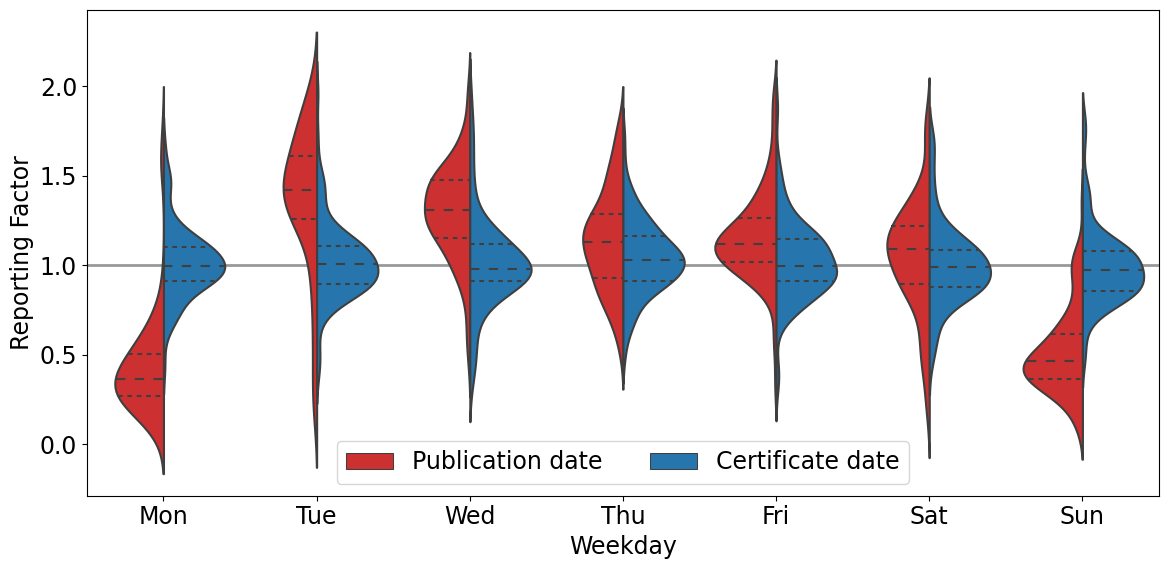

In [9]:
# Deaths-only violin for publication 
plt.rcParams['font.size'] = '17'
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.hlines(y=1, xmin=-1, xmax=7, linestyles="-", linewidth=2, alpha=0.8, color="gray", zorder=0)
rel_reporting_violin(df.copy(), ['newDeaths28DaysByPublishDate', 'newDeaths28DaysByDeathDate'],  ax=ax, cutoff=2,
                   colors=['tab:red', 'tab:blue'], labels=["Publish date", "Death date"])
for i in range(2):
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  
plt.xlabel('Weekday'); plt.ylabel("Reporting Factor"); 
plt.legend(handles=ax.legend_.legendHandles, labels=["Publication date", "Certificate date"], ncol=2, loc=8)
fig.patch.set_facecolor('white'); plt.tight_layout()
plt.savefig(f"../images/uk_phe_data/daily_violin_deaths_only.pdf")

In [10]:
def _my_print(list, print_output = True):
    output = [float('%.2g' % x) for x in list]
    return output if not print_output else print(output)

def print_weekday_tests(df, col):
    print("Test results for column: " + col)
    print("  T-test stat: " + str(_my_print(weekday_t_tests(df, col, p_vals = False), print_output=False)))
    print("  p values:    " + str(_my_print(weekday_t_tests(df, col, p_vals = True), print_output=False)))
    print("  Accept H0:   " + str(multiple_comparisons_correction(weekday_t_tests(df, col), 0.01)))

print_weekday_tests(df, 'Dif_newDeaths28DaysByPublishDate')
print_weekday_tests(df, 'Dif_newDeaths28DaysByDeathDate')

Test results for column: Dif_newDeaths28DaysByPublishDate
  T-test stat: [-16.0, 9.1, 11.0, 4.4, 6.5, 1.7, -16.0]
  p values:    [0.0, 5.8e-15, 0.0, 2.3e-05, 2.1e-09, 0.1, 0.0]
  Accept H0:   [False, False, False, False, False, True, False]
Test results for column: Dif_newDeaths28DaysByDeathDate
  T-test stat: [1.6, 0.97, 0.85, 2.3, 1.4, 0.55, 0.8]
  p values:    [0.11, 0.34, 0.4, 0.024, 0.15, 0.58, 0.43]
  Accept H0:   [True, True, True, True, True, True, True]


In [11]:
print(kruskal_weekday_test(df, 'Dif_newDeaths28DaysByPublishDate'))
print(kruskal_weekday_test(df, 'Dif_newDeaths28DaysByDeathDate'))

KruskalResult(statistic=356.0233751836002, pvalue=7.85692658054345e-74)
KruskalResult(statistic=6.067778689680108, pvalue=0.41564049333074793)


In [13]:
val = wilcoxon_signed_rank_test(df, 'newCasesByPublishDate', 'newCasesBySpecimenDate')
_my_print(val); print(multiple_comparisons_correction(val, 0.01))
val2 = wilcoxon_signed_rank_test(df, 'newDeaths28DaysByPublishDate', 'newDeaths28DaysByDeathDate')
_my_print(val2); print(multiple_comparisons_correction(val2, 0.01))

# do multiple hypothesis correction on this

[5.7e-18, 2.2e-15, 4.2e-08, 0.79, 0.00019, 2.4e-11, 0.13]
[False, False, False, True, False, False, True]
[1.2e-17, 4.2e-10, 9.7e-10, 0.0045, 0.0023, 0.19, 4.9e-17]
[False, False, False, False, False, True, False]


## Positivity Rates

There is still a weekly bias in positive tests by specimen date. Is this purely due to biases in the number of tests taken on a given day, or are there other factors at play here?

In [14]:
# Data methodology on UK government website allegedly is subject to a 7 day rolling average
# This can be removed, using custom functions that have been tested on known series
# However if they return negative values then this cannot be the product of a 7 day average

def cumsum_shift(s, shift = 1, init_values = [0]):
    """Function from user Gonzalo Polo at
    https://stackoverflow.com/questions/52456267/
    """
    s_cumsum = pd.Series(np.zeros(len(s)))
    for i in range(shift):
        s_cumsum.iloc[i] = init_values[i]
    for i in range(shift,len(s)):
        s_cumsum.iloc[i] = s_cumsum.iloc[i-shift] + s.iloc[i]
    return s_cumsum

def inv_roll_ave(series, window = 7):
    """'Undo' a moving average calculation of known window width"""
    s_diffed = 7 * series.diff()
    return cumsum_shift(s=s_diffed, shift=7, init_values=series[:window])


series = inv_roll_ave(df['newCasesBySpecimenDate'].bfill(inplace=False))
if min(series) > 0:
    df['newCasesBySpecimenDate'] = series
    print("Removed weekly average from data")


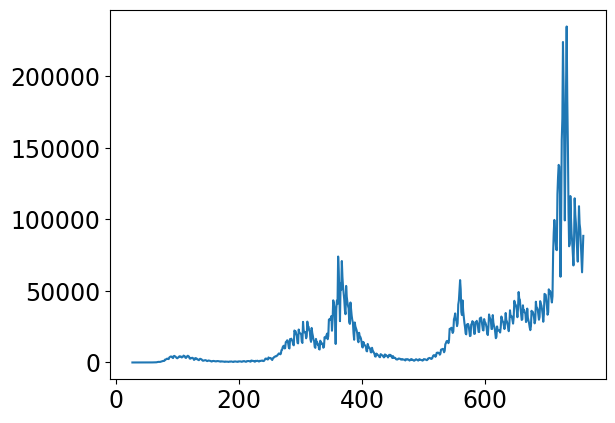

In [15]:
plt.plot(df.index, df['newCasesBySpecimenDate'])

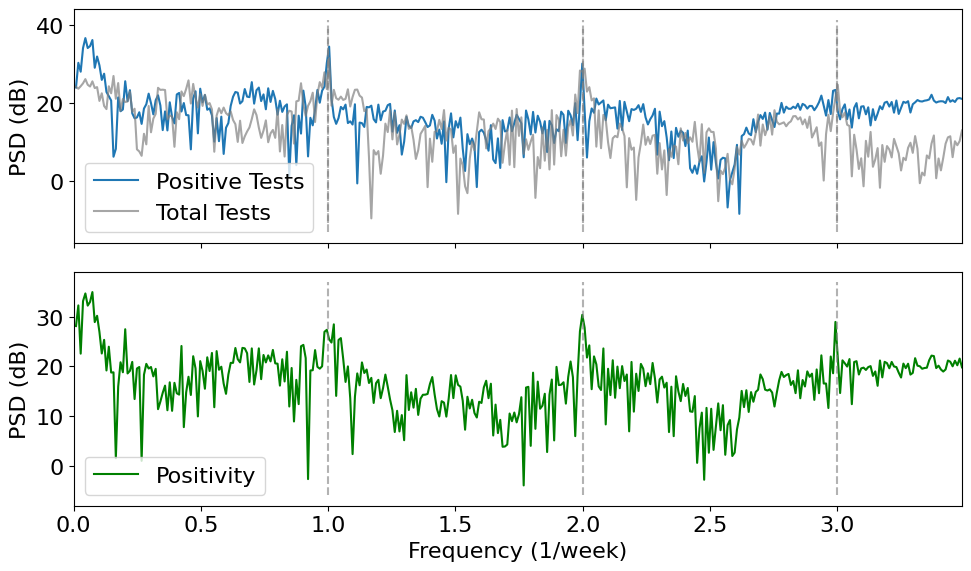

In [16]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(2, 1, figsize=(10,6))

df['positivityBySpecimenDate'] = df['newCasesBySpecimenDate'] / df['newVirusTestsBySpecimenDate']
df = ps.analysis.rel_reporting_calc(df, ['newVirusTestsBySpecimenDate', 'positivityBySpecimenDate'])

case_fft_pub, case_freq_pub = fourier_transform(df, column='Dif_newCasesBySpecimenDate', compute_psd=True)
plot_fft(case_fft_pub, case_freq_pub, ax=axs[0], color='tab:blue', label="Positive Tests")
case_fft_spec, case_freq_spec = fourier_transform(df, column='Dif_newVirusTestsBySpecimenDate', compute_psd=True)
plot_fft(case_fft_spec, case_freq_spec, ax=axs[0], color='grey', alpha=0.7, label="Total Tests")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft_pub, death_freq_pub = fourier_transform(df, column='Dif_positivityBySpecimenDate', compute_psd=True)
plot_fft(death_fft_pub, death_freq_pub, ax=axs[1], color='green', label="Positivity")

fig.patch.set_facecolor('white') ; fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_fft_tests.png")


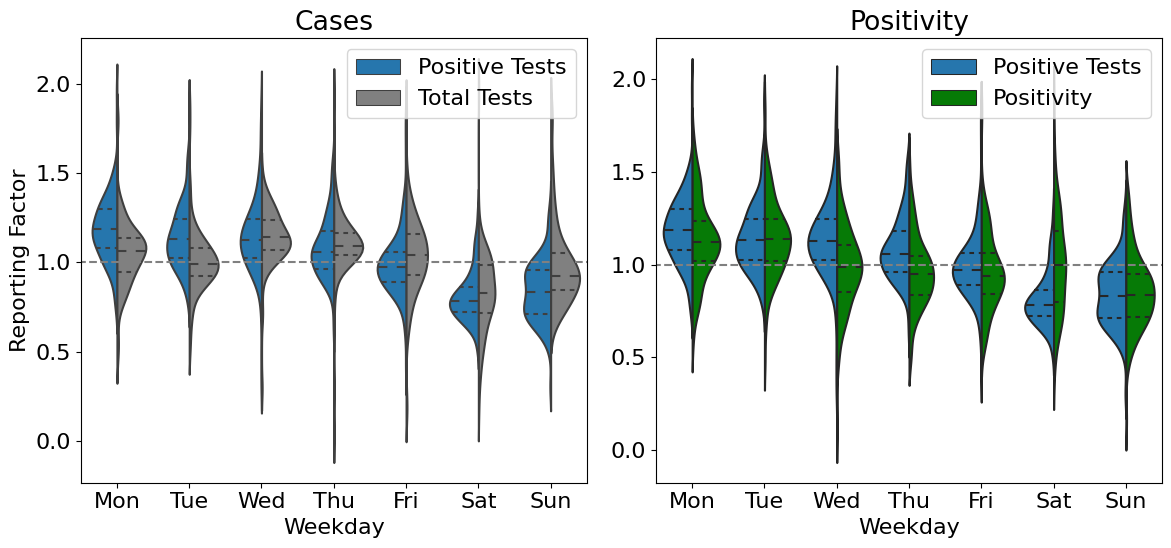

In [17]:
# separate violin for cases and deaths 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
ps.analysis.rel_reporting_violin(df.copy(), ['newCasesBySpecimenDate', 'newVirusTestsBySpecimenDate'],  ax=axs[0], cutoff=2,
                   colors=['tab:blue', 'grey'], labels=["Positive Tests", "Total Tests"])  
ps.analysis.rel_reporting_violin(df.copy(), ['newCasesBySpecimenDate', 'positivityBySpecimenDate'],  ax=axs[1], cutoff=2,
                   colors=['tab:blue', 'green'], labels=["Positive Tests", "Positivity"])
for i in range(2):
    axs[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  
plt.xlabel('Weekday'); axs[0].set_ylabel("Reporting Factor"); axs[1].set_ylabel("")
axs[0].set_title('Cases'); axs[1].set_title('Positivity')
plt.suptitle(''); plt.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_violin_cases_deaths.png")

In [18]:
print_weekday_tests(df, 'Dif_newCasesBySpecimenDate')
print_weekday_tests(df, 'Dif_newVirusTestsBySpecimenDate')
print_weekday_tests(df, 'Dif_positivityBySpecimenDate')

Test results for column: Dif_newCasesBySpecimenDate
  T-test stat: [7.8, 5.6, 5.4, 3.3, 0.7, -12.0, -2.6]
  p values:    [3.4e-12, 2e-07, 5e-07, 0.0014, 0.49, 0.0, 0.01]
  Accept H0:   [False, False, False, False, True, False, True]
Test results for column: Dif_newVirusTestsBySpecimenDate
  T-test stat: [3.0, 1.2, 7.1, 4.9, 1.7, -6.0, 0.79]
  p values:    [0.0034, 0.24, 1.2e-10, 3e-06, 0.084, 2.9e-08, 0.43]
  Accept H0:   [False, True, False, False, True, False, True]
Test results for column: Dif_positivityBySpecimenDate
  T-test stat: [5.4, 5.5, -1.1, -2.8, -0.67, -0.34, -1.8]
  p values:    [4.6e-07, 2.2e-07, 0.28, 0.0067, 0.5, 0.73, 0.073]
  Accept H0:   [False, False, True, True, True, True, True]


In [22]:
print(kruskal_weekday_test(df, 'Dif_newVirusTestsBySpecimenDate'))
print(kruskal_weekday_test(df, 'Dif_positivityBySpecimenDate'))

KruskalResult(statistic=181.06367384649093, pvalue=2.0169214385197392e-36)
KruskalResult(statistic=117.08315895835919, pvalue=6.67495376351293e-23)


## PCR Tests

It is possible that the significant noise in case reporting is due to confounding factors associated with home LFT tests, so we will consider whether these factors are removed when considering only PCR tests.

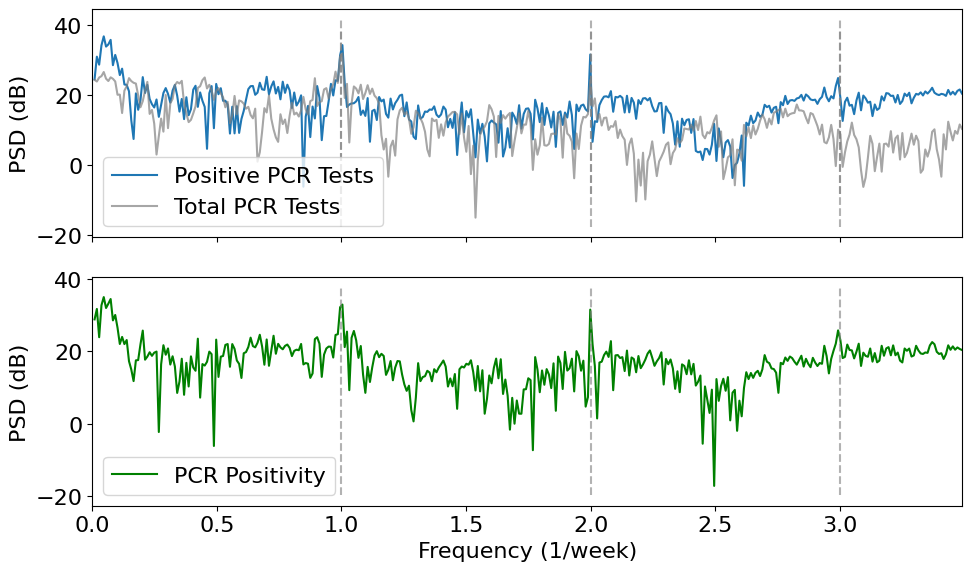

In [19]:
plt.rcParams['font.size'] = '16'
fig, axs = plt.subplots(2, 1, figsize=(10,6))

df['positivityPCRBySpecimenDate'] = df['newCasesPCROnlyBySpecimenDate'] / df['newPCRTestsBySpecimenDate']
df = ps.analysis.rel_reporting_calc(df, ['newPCRTestsBySpecimenDate', 'newCasesPCROnlyBySpecimenDate', 'positivityPCRBySpecimenDate'])

case_fft_pub, case_freq_pub = fourier_transform(df, column='Dif_newCasesPCROnlyBySpecimenDate', compute_psd=True)
plot_fft(case_fft_pub, case_freq_pub, ax=axs[0], color='tab:blue', label="Positive PCR Tests")
case_fft_spec, case_freq_spec = fourier_transform(df, column='Dif_newPCRTestsBySpecimenDate', compute_psd=True)
plot_fft(case_fft_spec, case_freq_spec, ax=axs[0], color='grey', alpha=0.7, label="Total PCR Tests")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft_pub, death_freq_pub = fourier_transform(df, column='Dif_positivityPCRBySpecimenDate', compute_psd=True)
plot_fft(death_fft_pub, death_freq_pub, ax=axs[1], color='green', label="PCR Positivity")

fig.patch.set_facecolor('white') ; fig.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_fft_pcr_tests.png")


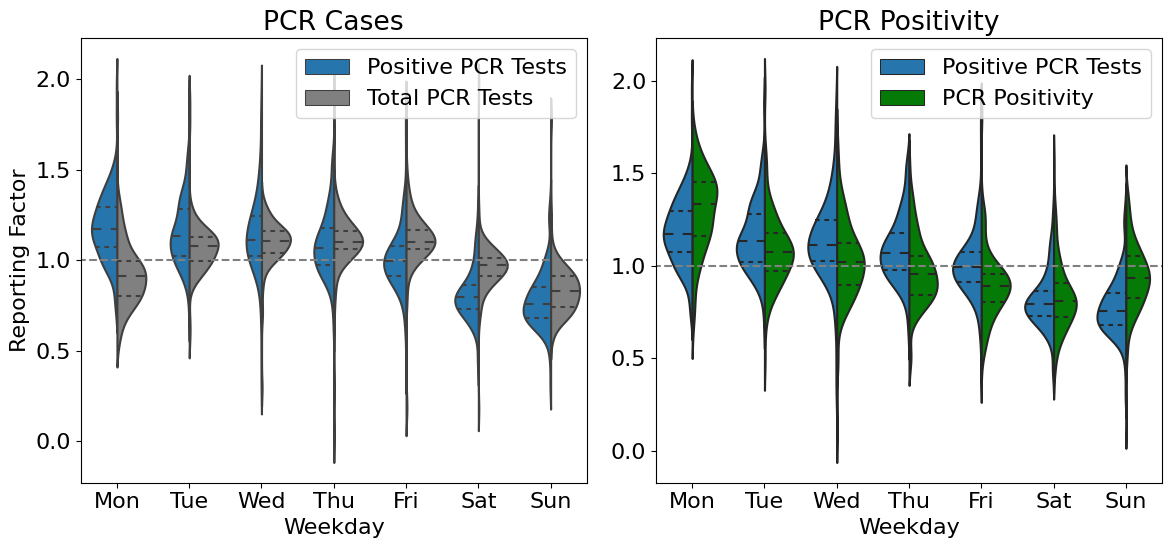

In [20]:
# separate violin for cases and deaths 
fig, axs = plt.subplots(1, 2, figsize=(12,6))
ps.analysis.rel_reporting_violin(df.copy(), ['newCasesPCROnlyBySpecimenDate', 'newPCRTestsBySpecimenDate'],  ax=axs[0], cutoff=2,
                   colors=['tab:blue', 'grey'], labels=["Positive PCR Tests", "Total PCR Tests"])  
ps.analysis.rel_reporting_violin(df.copy(), ['newCasesPCROnlyBySpecimenDate', 'positivityPCRBySpecimenDate'],  ax=axs[1], cutoff=2,
                   colors=['tab:blue', 'green'], labels=["Positive PCR Tests", "PCR Positivity"])
for i in range(2):
    axs[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  
plt.xlabel('Weekday'); axs[0].set_ylabel("Reporting Factor"); axs[1].set_ylabel("")
axs[0].set_title('PCR Cases'); axs[1].set_title('PCR Positivity')
plt.suptitle(''); plt.tight_layout()
# plt.savefig(f"../images/uk_phe_data/daily_violin_pcr_tests.png")

In [21]:
print_weekday_tests(df, 'Dif_newCasesPCROnlyBySpecimenDate')
print_weekday_tests(df, 'Dif_newPCRTestsBySpecimenDate')
print_weekday_tests(df, 'Dif_positivityPCRBySpecimenDate')

Test results for column: Dif_newCasesPCROnlyBySpecimenDate
  T-test stat: [7.8, 5.9, 5.1, 3.4, 1.1, -11.0, -3.9]
  p values:    [4.4e-12, 4.2e-08, 1.4e-06, 0.0008, 0.29, 0.0, 0.00017]
  Accept H0:   [False, False, False, False, True, False, False]
Test results for column: Dif_newPCRTestsBySpecimenDate
  T-test stat: [-2.2, 4.7, 5.5, 5.1, 6.3, -1.1, -5.0]
  p values:    [0.028, 8.8e-06, 2.5e-07, 1.7e-06, 6.8e-09, 0.28, 2.2e-06]
  Accept H0:   [True, False, False, False, False, True, False]
Test results for column: Dif_positivityPCRBySpecimenDate
  T-test stat: [12.0, 3.4, 0.55, -2.4, -2.3, -8.7, -0.19]
  p values:    [0.0, 0.00097, 0.59, 0.019, 0.025, 5e-14, 0.85]
  Accept H0:   [False, False, True, True, True, False, True]
